In [1]:
import tensorflow as tf
import sklearn

In [26]:
import csv
import io
import urllib3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold, cross_val_score
from sklearn import linear_model, datasets
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

In [3]:

# Set seed for shuffling
RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Clustering

1)	FRESH: annual spending (m.u.) on fresh products (Continuous); 

2)	MILK: annual spending (m.u.) on milk products (Continuous); 

3)	GROCERY: annual spending (m.u.)on grocery products (Continuous); 

4)	FROZEN: annual spending (m.u.)on frozen products (Continuous) 

5)	DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous) 

6)	DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous); 

7)	CHANNEL: customers' Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal) 

8)	REGION: customers' Region - Lisnon, Oporto or Other (Nominal) 

Task:
The goal of this task is to do some k-means clustering with the continuous variables above and see if we can derive any unique findings about the Channel or Region columns of the dataset.

Preprocessing:
All we have to do is get the csv from the url and place it in an object.

In [13]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
data = pd.read_csv(url, header = 0)

In [11]:
#Variables for the features and target variables.
CustomerData = np.split(data, [2], axis=1)[1]
Targets = np.split(data, [2], axis=1)[0]
Targets = np.split(Targets, [1], axis=1)

In [14]:
#Using PCA to make the data readable on the 2d plot as well as simplify the clustering process.
pca = PCA(n_components=2)
pca.fit(CustomerData)

CustomersDataPCA = pca.transform(CustomerData)

#I really didn't want to do this at first because I thought this may be unsupervised learning
#But it is now classification so I need to make a training and test set.
x_train_cluster, x_test_cluster, y_train_cluster, y_test_cluster = train_test_split(CustomersDataPCA, Targets[0], test_size=0.2)

## sklearn

In [22]:
# Instantiate
clusterer = KMeans(n_clusters=3, max_iter=1000, n_init=20).fit(CustomersDataPCA, Targets[1])

In [23]:
preds = clusterer.predict(CustomersDataPCA)
centers = clusterer.cluster_centers_

In [25]:
#I'll use a confusion matrix to score these two models
confusion_matrix(Targets[1], preds)

array([[  0,   0,   0,   0],
       [ 56,  11,  10,   0],
       [ 35,   4,   8,   0],
       [238,  45,  33,   0]], dtype=int64)

## TensorFlow

In [32]:
N=CustomersDataPCA.shape[0]
K=3
MAX_ITERS = 1000
import time

start = time.time()

points = tf.Variable(CustomersDataPCA)
cluster_assignments = tf.Variable(tf.zeros([N], dtype=tf.int64))

# Silly initialization:  Use the first K points as the starting
# centroids.  In the real world, do this better.
centroids = tf.Variable(tf.slice(points.initialized_value(), [0,0], [K,2]))

# Replicate to N copies of each centroid and K copies of each
# point, then subtract and compute the sum of squared distances.
rep_centroids = tf.reshape(tf.tile(centroids, [N, 1]), [N, K, 2])
rep_points = tf.reshape(tf.tile(points, [1, K]), [N, K, 2])
sum_squares = tf.reduce_sum(tf.square(rep_points - rep_centroids), 
                            reduction_indices=2)

# Use argmin to select the lowest-distance point
best_centroids = tf.argmin(sum_squares, 1)
did_assignments_change = tf.reduce_any(tf.not_equal(best_centroids, 
                                                    cluster_assignments))

def bucket_mean(data, bucket_ids, num_buckets):
    total = tf.unsorted_segment_sum(data, bucket_ids, num_buckets)
    count = tf.unsorted_segment_sum(tf.ones_like(data), bucket_ids, num_buckets)
    return total / count

means = bucket_mean(points, best_centroids, K)

# Do not write to the assigned clusters variable until after
# computing whether the assignments have changed - hence with_dependencies
with tf.control_dependencies([did_assignments_change]):
    do_updates = tf.group(
        centroids.assign(means),
        cluster_assignments.assign(best_centroids))

init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

changed = True
iters = 0

while changed and iters < MAX_ITERS:
    iters += 1
    [changed, _] = sess.run([did_assignments_change, do_updates])

[centers, assignments] = sess.run([centroids, cluster_assignments])
end = time.time()
print (("Found in %.2f seconds" % (end-start)), iters, "iterations")
print ("Centroids:")
print (centers)
print ("Cluster assignments:", assignments)
confusion_matrix(Targets[1], assignments)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Found in 0.21 seconds 15 iterations
Centroids:
[[23978.86566553 -4445.56611772]
 [-1341.31124554 25261.39189714]
 [-4165.1217824  -3105.15811456]]
Cluster assignments: [2 2 2 2 0 2 2 2 2 1 2 2 0 2 0 2 2 2 2 2 2 2 0 1 0 2 2 2 1 0 2 2 2 0 2 2 0
 2 1 0 0 2 2 1 2 1 1 1 2 1 2 2 0 2 0 2 1 2 2 2 2 1 2 1 2 1 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 2 2 2 2 1 1 0 2 0 2 2 1 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 1 2
 1 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 1 2 2
 2 0 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 1 2 1 2 2 0 2 2 2 2 0 2 0 2
 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 1 1 0 2 2 1 2 2 2 1 2 1 2 2 2 2 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 2 2 1 2 0 2 0 2 2 0
 0 2 2 0 2 2 1 1 2 1 2 2 2 2 0 2 2 0 2 2 2 2 2 0 0 0 0 2 2 2 0 2 2 2 2 2 2
 2 2 2 2 2 1 2 2 1 2 1 2 2 1 2 0 1 2 2 2 2 2 2 1 2 2 2 2 0 0 2 2 2 2 2 1 2
 1 2 0 2 2 2 2 2 2 2 1 2 2 2 0 2 1 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 0 2 2 2

array([[  0,   0,   0,   0],
       [ 11,  10,  56,   0],
       [  4,   8,  35,   0],
       [ 45,  33, 238,   0]], dtype=int64)

# Linear Regression

The dataset contains eight attributes (or features, denoted by X1...X8) and two responses (or outcomes, denoted by y1 and y2). The aim is to use the eight features to predict each of the two responses. 

Specifically: 
X1	Relative Compactness 
X2	Surface Area 
X3	Wall Area 
X4	Roof Area 
X5	Overall Height 
X6	Orientation 
X7	Glazing Area 
X8	Glazing Area Distribution 
y1	Heating Load 
y2	Cooling Load

Like clustering we bring in the data and separate it into train and test sets

In [41]:
enurl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'
endata = pd.read_excel(enurl, header = 0,sheet_name=0).values

In [42]:
energyParameters = endata[:, 0:8]
energyTarget = endata[:, 8:10]

x_train_energy, x_test_energy, y_train_energy, y_test_energy = train_test_split(energyParameters, energyTarget, test_size=0.2)

## sklearn

In [74]:
linRegr = linear_model.LinearRegression()
linRegr.fit(x_train_energy, y_train_energy[:, 0])
print("Heating Load:", linRegr.predict(x_test_energy))

Heating Load: [  7.63542373  33.88542373  36.88542373  25.63542373  32.13542373
  13.38542373  27.13542373  29.38542373  33.88542373  17.63542373
  16.13542373  15.13542373  16.13542373  27.88542373  12.88542373
  32.88542373   8.13542373  14.51042373  31.13542373  15.13542373
  11.88542373  28.63542373  15.13542373  29.13542373  32.63542373
  29.63542373  13.38542373  33.63542373  16.38542373  29.88542373
  16.63542373  31.63542373  15.13542373  16.13542373  37.13542373
  14.38542373  17.88542373  24.38542373  35.63542373  13.38542373
  15.88542373  12.13542373  10.63542373  15.38542373  26.88542373
  22.38542373  29.13542373  14.88542373  29.13542373  36.88542373
  24.88542373   8.38542373   5.51042373  25.38542373  26.13542373
  18.13542373  15.88542373  29.13542373  12.13542373  17.88542373
  11.38542373  12.88542373  24.38542373  32.13542373  29.13542373
  17.63542373  29.13542373  24.63542373  10.76042373  22.38542373
  37.38542373  27.88542373  14.38542373  25.38542373  29.63542

In [78]:
# The coefficients
print('Coefficients:', linRegr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((linRegr.predict(x_test_energy) - y_test_energy[:,0]) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linRegr.score(x_test_energy, y_test_energy[:,0]))

Coefficients: [ -6.93420455e+01   4.56780295e+12  -4.56780295e+12  -9.13560589e+12
   3.71577454e+00  -1.90298557e-02   2.01898388e+01   1.52906656e-01]
Residual sum of squares: 11.53
Variance score: 0.89


In [79]:
linRegr = linear_model.LinearRegression()
linRegr.fit(x_train_energy, y_train_energy[:, 1])
print("Cooling Load:", linRegr.predict(x_test_energy))

Cooling Load: [ 11.77498165  34.77498165  37.27498165  29.02498165  33.77498165
  15.77498165  29.27498165  31.52498165  35.27498165  19.02498165
  17.02498165  16.52498165  17.52498165  30.27498165  15.77498165
  33.77498165  11.52498165  16.02498165  32.52498165  17.02498165
  14.52498165  31.02498165  16.77498165  31.02498165  34.02498165
  31.52498165  15.27498165  35.02498165  17.52498165  31.52498165
  17.77498165  33.27498165  17.02498165  17.77498165  37.27498165
  16.02498165  19.52498165  28.02498165  36.27498165  15.77498165
  16.77498165  14.77498165  14.27498165  17.27498165  29.52498165
  24.52498165  31.77498165  17.02498165  31.52498165  37.27498165
  26.02498165  11.52498165  10.27498165  28.77498165  29.02498165
  19.27498165  17.02498165  31.77498165  15.02498165  19.27498165
  13.77498165  15.77498165  28.02498165  33.77498165  31.52498165
  19.02498165  31.02498165  26.27498165  13.77498165  24.77498165
  37.27498165  30.27498165  16.27498165  28.77498165  31.52498

In [80]:
# The coefficients
print('Coefficients:', linRegr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((linRegr.predict(x_test_energy) - y_test_energy[:,0]) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linRegr.score(x_test_energy, y_test_energy[:,0]))

Coefficients: [ -7.53976859e+01   6.36358826e+12  -6.36358826e+12  -1.27271765e+13
   3.88533783e+00   1.00033641e-01   1.47861523e+01   7.20119476e-03]
Residual sum of squares: 14.81
Variance score: 0.85


## TensorFlow

I tried so many different ways to do this but they all failed. I will stick to how the book does it here but leave the rest below for my own reference. Plus, I don't want to look like I just took the book answer. Took me hours to get here.

In [44]:
#We need to use a scalar with bias in the DS to use gradient descent optimizer. This code was mainly from the book
from sklearn.preprocessing import StandardScaler
m, n = energyParameters.shape
scaler = StandardScaler()
scaled_energy_data = scaler.fit_transform(energyParameters)
scaled_energy_data_plus_bias = np.c_[np.ones((m, 1)), scaled_energy_data]

In [45]:
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_energy_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(energyTarget[:,0:1].reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [46]:
#Decided to go with an optimizer for fun.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

In [47]:
#Run the graph constructed above. the MSE gets to around 9. This is a better score than the sklearn model above by 2 points.
#Note that this one is for the heating score. Also note that there is no activation function and mse is computed each epoch.
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 616.17834
Epoch 100 MSE = 19.7918
Epoch 200 MSE = 10.404517
Epoch 300 MSE = 9.947573
Epoch 400 MSE = 9.703575
Epoch 500 MSE = 9.507805
Epoch 600 MSE = 9.348815
Epoch 700 MSE = 9.219578
Epoch 800 MSE = 9.114436
Epoch 900 MSE = 9.028812
Best theta:
[[22.30715   ]
 [-1.7665867 ]
 [-1.3256218 ]
 [ 2.0819826 ]
 [-1.4799418 ]
 [ 7.1799374 ]
 [-0.02608395]
 [ 2.6537151 ]
 [ 0.31584576]]


In [48]:
#Now lets do it for cooling score. Pretty much same score here as the heating score. Cool. Both beat sklearn.

y = tf.constant(energyTarget[:,1:2].reshape(-1, 1), dtype=tf.float32, name="y")
error = y_pred - y

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 616.17834
Epoch 100 MSE = 19.7918
Epoch 200 MSE = 10.404517
Epoch 300 MSE = 9.947573
Epoch 400 MSE = 9.703575
Epoch 500 MSE = 9.507805
Epoch 600 MSE = 9.348815
Epoch 700 MSE = 9.219578
Epoch 800 MSE = 9.114436
Epoch 900 MSE = 9.028812
Best theta:
[[22.30715   ]
 [-1.7665867 ]
 [-1.3256218 ]
 [ 2.0819826 ]
 [-1.4799418 ]
 [ 7.1799374 ]
 [-0.02608395]
 [ 2.6537151 ]
 [ 0.31584576]]


Here is the failed code. No need to look down any further unless you want to see attempts.

In [114]:
tryx = x_train_energy[:,0:8]
tryy = y_train_energy[:,0:1]

In [106]:
# Parameters
learning_rate = 0.01
training_epochs = 100
display_step = 50
n_samples = x_train_energy.shape[0]
cost_history = np.empty(shape=[1],dtype=float)

In [116]:
# tf Graph Input
X = tf.placeholder(tf.float32, shape=(None, 8), name="X")
Y = tf.placeholder(tf.int64, shape=(None), name="Y")

# Set model weights
W = tf.Variable(np.random.randn(), name="weight")
b = tf.Variable(np.random.randn(), name="bias")

In [109]:
# Construct a linear model
pred = tf.add(tf.multiply(X, W), b)

# Mean squared error
cost = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*n_samples)
# Gradient descent
#  Note, minimize() knows to modify W and b because Variable objects are trainable=True by default
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [117]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Fit all training data
    for epoch in range(training_epochs):
        for (x, y) in zip(tryx, tryy):
            sess.run(optimizer, feed_dict={X: x, Y: y})

        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c = sess.run(cost, feed_dict={X: tryx, Y:tryy})
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), \
                "W=", sess.run(W), "b=", sess.run(b))

    print("Optimization Finished!")
    training_cost = sess.run(cost, feed_dict={X: tryx, Y: tryy})
    print("Training cost=", training_cost, "W=", sess.run(W), "b=", sess.run(b), '\n')

    # Graphic display
    plt.plot(tryx, tryy, 'ro', label='Original data')
    plt.plot(tryx, sess.run(W) * tryx + sess.run(b), label='Fitted line')
    plt.legend()
    plt.show()

ValueError: Cannot feed value of shape (8,) for Tensor 'X_8:0', which has shape '(?, 8)'

In [99]:
# Start training
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    for (x, y) in zip(x_train_energy, y_train_energy[:,0:1]):
        sess.run(optimizer, feed_dict={X: x, Y: y})
    cost_history = np.append(cost_history,sess.run(cost,feed_dict={X: x_train_energy,Y: y_train_energy[:,0:1]}))

InvalidArgumentError: In[0] is not a matrix
	 [[Node: MatMul_3 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_Placeholder_26_0_0, Variable_1/read)]]

Caused by op 'MatMul_3', defined at:
  File "C:\Program Files\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Program Files\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Program Files\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-97-d90285ddaa9c>", line 5, in <module>
    y_ = tf.matmul(X, W)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1844, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 1289, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): In[0] is not a matrix
	 [[Node: MatMul_3 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_Placeholder_26_0_0, Variable_1/read)]]


C:\Program Files\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


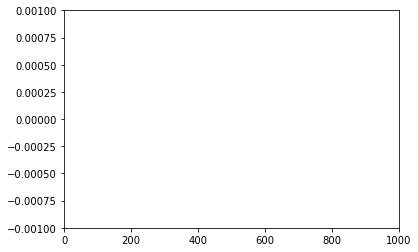

In [89]:
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

MSE: nan


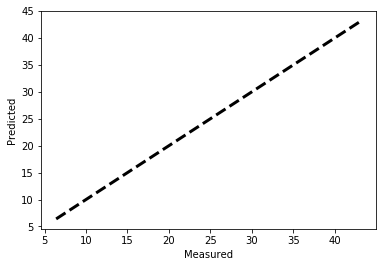

In [90]:
pred_y = sess.run(y_, feed_dict={X: x_test_energy})
mse = tf.reduce_mean(tf.square(pred_y - y_test_energy[:,0:1]))
print("MSE: %.4f" % sess.run(mse)) 

fig, ax = plt.subplots()
ax.scatter(y_test_energy[:,0:1], pred_y)
ax.plot([y_test_energy[:,0:1].min(), y_test_energy[:,0:1].max()], [y_test_energy[:,0:1].min(), y_test_energy[:,0:1].max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [102]:
sess.close()

In [98]:
# Build the Estimator.
model = tf.estimator.LinearRegressor(feature_columns=x_train_energy)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\McNair\\AppData\\Local\\Temp\\tmplcz5i7ic', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


In [101]:
model.train(input_fn=x_train_energy, steps=1000)

TypeError: unsupported callable

# Classification

6 Attributes in total (1 goal field, 1 non-predictive, 4 predictive attributes) 

1. BI-RADS assessment: 1 to 5 (ordinal, non-predictive!) 
2. Age: patient's age in years (integer) 
3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal) 
4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal) 
5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal) 
6. Severity: benign=0 or malignant=1 (binominal, goal field!) 

This one is pretty straightforward. Predict tumor malignancy. Bring in the data and separate into training and test.

In [51]:
mammurl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data'
mammdata = pd.read_csv(mammurl, header = None)
#Get rid of the null values. It will just be a pain to deal with
mammdata = mammdata.replace(['?'], [None]).dropna().values

In [52]:
x = mammdata[:, 0:5]
y = mammdata[:, 5].astype('int')
x_mamm_train, x_mamm_test, y_mamm_train, y_mamm_test = train_test_split(x, y, test_size=0.2, random_state=0)

## sklearn

In [53]:
#Simple. Use logistic regression as a classifier
logreg = linear_model.LogisticRegression()
logreg.fit(x_mamm_train, y_mamm_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
#Show the scores. Not terrible. .728 F1 score. definitely better than a coin flip.
kf = KFold(len(y_mamm_test), n_folds=5, shuffle=True, random_state=0)
scores = cross_val_score(logreg, x_mamm_test, y_mamm_test, cv=kf, scoring="precision")
print( "Precision: {0:.3f}".format(np.mean(scores)))
scores = cross_val_score(logreg, x_mamm_test, y_mamm_test, cv=kf, scoring="recall")
print( "Recall: {0:.3f}".format(np.mean(scores)))
scores = cross_val_score(logreg, x_mamm_test, y_mamm_test, cv=kf, scoring="f1")
print( "F1: {0:.3f}".format(np.mean(scores)))

Precision: 0.706
Recall: 0.754
F1: 0.728


## Tensorflow

In [60]:
#This code I basically used when making a single layer DNN. Let's use it again. I dont think there needs to be many nodes in
#The hidden layer as there are only 5 inputs. I used a bigger number anyway because why not.
reset_graph()

#Set the layers size
n_inputs = 5 # 5 inputs, 1 for each param
n_hidden1 = 256 # Number of hidden layer nodes
n_outputs = 2 # Number of outputs, benign or malignant

# Set the place holders 
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

# function for creating neuron layers
# Could be replaced with dense but will keep this for reference
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.ones([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z
        
#Create our DNN using the function above or the dense function
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden1, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [61]:
#Execution phase and output. Not a bad score. A slight increase from the sklearn but not much. More 
#learning and mroe hyper parameter tuning could probably inch up the score for us.
n_epochs = 40
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for i in range(len(x_mamm_train)):
            sess.run(training_op, feed_dict={X: x_mamm_train[i: i + 1], y: y_mamm_train[i: i + 1]})
            
        acc_train = accuracy.eval(feed_dict={X: x_mamm_train, y: y_mamm_train})
        acc_test = accuracy.eval(feed_dict={X: x_mamm_test, y: y_mamm_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.5165663 Test accuracy: 0.42168674
1 Train accuracy: 0.55421686 Test accuracy: 0.4759036
2 Train accuracy: 0.563253 Test accuracy: 0.48795182
3 Train accuracy: 0.5933735 Test accuracy: 0.5180723
4 Train accuracy: 0.57981926 Test accuracy: 0.5
5 Train accuracy: 0.57228917 Test accuracy: 0.5
6 Train accuracy: 0.57981926 Test accuracy: 0.5120482
7 Train accuracy: 0.56626505 Test accuracy: 0.48795182
8 Train accuracy: 0.561747 Test accuracy: 0.48192772
9 Train accuracy: 0.55873495 Test accuracy: 0.48795182
10 Train accuracy: 0.67469877 Test accuracy: 0.6084337
11 Train accuracy: 0.5813253 Test accuracy: 0.5120482
12 Train accuracy: 0.6295181 Test accuracy: 0.5421687
13 Train accuracy: 0.5768072 Test accuracy: 0.5060241
14 Train accuracy: 0.57530123 Test accuracy: 0.5180723
15 Train accuracy: 0.58885545 Test accuracy: 0.5180723
16 Train accuracy: 0.6987952 Test accuracy: 0.64457834
17 Train accuracy: 0.563253 Test accuracy: 0.5
18 Train accuracy: 0.77259034 Test accuracy: